<div style="display: flex;">
    <img src="logo.png" alt="Logo" style="width: 100px; margin-left: 0; margin-right: 20px"/>
    <h1>Desertification in Mali, 2020-2025</h1>
</div>

### Visualizing input data
This notebook serves as an initial exploration of the data for the desertification project. It also outlines the rationale behind key data decisions.

In this notebook, I will:
- Visualize Sentinel-2 images
- Calculate the NDVI using the Red and NIR bands
- Perform basic land cover classification based on the NDVI to estimate the extent of vegetated areas

In [49]:
import rasterio
import os
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
import psutil
import gc

### Input Data

For this project, I chose Sentinel-2 data due to its relatively high spatial resolution compared to Landsat, and because I am not conducting historical analysis that requires a long track record.

The images were taken around Nara, Mali, located at the edge of the Sahel, an area experiencing increasing desertification due to deforestation, overgrazing, and climate change. Local initiatives to combat desertification have been implemented, so we can expect both land degradation and restoration.

I selected images from the dry season (December - April) for the following reasons:

- The landscape is at its most arid, making it easier to detect areas transitioning into desert.
- Cloud cover is minimal compared to the rainy season, allowing for clearer satellite imagery.
- NDVI values will be at their lowest, making vegetation loss more apparent.

Only images with 0% cloud cover were used for this analysis.
The images were downloaded from [Copernicus Open Access Hub](https://browser.dataspace.copernicus.eu).

In [ ]:
# Define File Paths
base_path = '../data/raw_tiles/S2C_MSIL2A_20250223T105101_N0511_R051_T29PPS_20250223T150955.SAFE/GRANULE/L2A_T29PPS_A002452_20250223T105754/IMG_DATA/'
file_path_B02 = base_path + 'R10m/T29PPS_20250223T105101_B02_10m.jp2' # blue
file_path_B03 = base_path + 'R10m/T29PPS_20250223T105101_B03_10m.jp2' # green
file_path_B04 = base_path + 'R10m/T29PPS_20250223T105101_B04_10m.jp2' # red
file_path_B08 = base_path + 'R10m/T29PPS_20250223T105101_B08_10m.jp2' # NIR
file_path_B11 = base_path + 'R20m/T29PPS_20250223T105101_B11_20m.jp2' # SWIR

# Open and Read JP2 Files
with rasterio.open(file_path_B02) as src_B02, rasterio.open(file_path_B03) as src_B03, rasterio.open(file_path_B04) as src_B04, rasterio.open(file_path_B08) as src_B08, rasterio.open(file_path_B11) as src_B11:
    B02 = src_B02.read(1).astype(float)
    B03 = src_B03.read(1).astype(float)
    B04 = src_B04.read(1).astype(float)
    B08 = src_B08.read(1).astype(float)

    # Note that B11 has a spatial resolution of 20m, so in order to do calculations we will have to resample it to 10m
    B11 = src_B11.read(
        out_shape=(src_B11.count, src_B03.height, src_B03.width),
        resampling=Resampling.bilinear
    ).astype(float)

### Calculating and visualizing the NDVI

The Siamese network that I will be using for change detection will take three inputs:

1. A "before" image. This will be created by calculating the NDVI for multiple dates within a specific time period and then averaging the NDVI values for those dates.
2. An "after" image. Similarly, the "after" image will be generated by calculating the NDVI for several dates within a different time period and averaging the NDVI values. The time period for averaging in this step will correspond to the time period used for the "before" image.
3. A change mask. This mask will specify the changes of interest and will contain three classes:
<ul style="list-style-type: none">
    <li>0: No change</li>
        <li>1: Desertification</li>
        <li>2: Restoration</li>
    <ul>

In [51]:
# Calculate NDVI
ndvi = (B08 - B04) / (B08 + B04)

In [16]:
# Print quartiles and min/max values for index and plot the index map and the histogram
def plot_index(index_name, index_data):
    quartiles = np.percentile(index_data, [25, 50, 75])
    min_val = np.min(index_data)
    max_val = np.max(index_data)
    print(f"{index_name} quartiles: 25th={quartiles[0]}, 50th={quartiles[1]}, 75th={quartiles[2]}")
    print(f"{index_name} min: {min_val}, {index_name} max: {max_val}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Display NDVI image
    im = ax1.imshow(index_data, cmap='RdYlGn', extent=(src_B04.bounds.left, src_B04.bounds.right, src_B04.bounds.bottom, src_B04.bounds.top))
    ax1.set_title(index_name + ' map')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    # Display NDVI histogram
    ax2.hist(index_data.flatten(), bins=50, color='green', alpha=0.7)
    ax2.set_title('Histogram of ' + index_name)
    ax2.set_xlabel(index_name + ' value')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

NDVI quartiles: 25th=0.12603773584905661, 50th=0.1392988929889299, 75th=0.15289821999087175
NDVI min: -0.21258633921719108, NDVI max: 0.5986860114973994


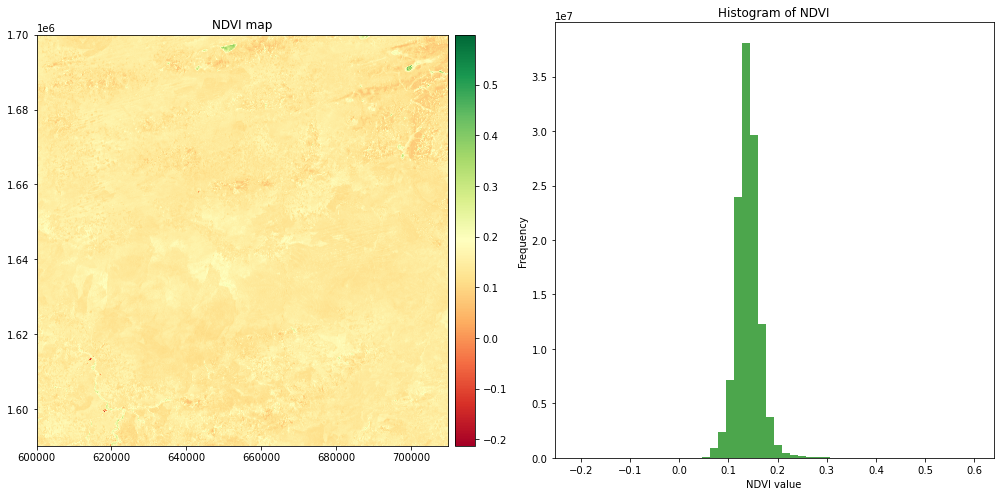

In [17]:
plot_index("NDVI", ndvi)

In [ ]:
# Scale NDVI to uint16
ndvi_scaled = ((ndvi + 1) * (2**15 - 1)).astype(np.uint16)

# Write NDVI to a new file
ndvi_file_path = '../data/ndvi20250223.jp2'
ndvi_meta = src_B04.meta.copy()
ndvi_meta.update(dtype=rasterio.uint16, count=1)

with rasterio.open(ndvi_file_path, 'w', **ndvi_meta) as dst:
    dst.write(ndvi_scaled, 1)

### Land cover classification based on the NDVI to estimate the extent of vegetated areas

The first step in this project will be to mask anything that is not either vegetation or barren land. A good approach for this would be to use existing land use/land cover (LULC) maps. 

However, in this project, I'm going to use:
- the Normalized Difference Water Index (NDWI) for water defined by McFeeters (1996), with formula $NDWI = \frac{Green – SWIR}{Green + SWIR}$

- the Built-Up Index (BUI) for urban area identification. This index was proposed by He et al. (2010) and is defined as $BUI = NDBI − NDVI$, where $NDBI = \frac{SWIR − NIR}{SWIR + NIR}$

In [52]:
# Calculate NDWI and BUI
ndwi = (B03 - B11) / (B03 + B11)
ndbi = (B11 - B08) / (B11 + B08)
bui = ndbi - ndvi

General guidelines are that :
<ul>
    <li>NDWI > 0 → Water (with 0.3 or higher being confident)</li>
    <li>NDWI ≤ 0 → Non-water (land, vegetation, built-up areas)</li>
</ul>

and

<ul>
    <li>BUI > 0 → Built-up area (with 0.2 or higher being confident)</li>
    <li>BUI ≤ 0 → Vegetation or natural land cover</li>
</ul>

In [53]:
water_mask = np.zeros_like(ndwi)
water_mask[(ndwi <= 0)] = 1

builtup_mask = np.zeros_like(bui)
builtup_mask[(bui <= 0.1)] = 1

Let's remove some variables so that we don't run out of RAM

In [54]:
memory_before = psutil.virtual_memory().used / (1024 ** 3)
print(f"Memory usage before: {memory_before:.2f} GB")

del B08, B11, ndvi, ndwi, bui

collected = gc.collect()
print(f"Garbage collector: collected {collected} objects.")

memory_after = psutil.virtual_memory().used / (1024 ** 3)
print(f"Memory usage after: {memory_after:.2f} GB")

Memory usage before: 23.30 GB
Garbage collector: collected 25752 objects.
Memory usage after: 16.95 GB


But of course the threshold depends on the vegetation and urban contrast in a region. Therefore, we will also plot them for a reference area to see if these cutoffs make sense.

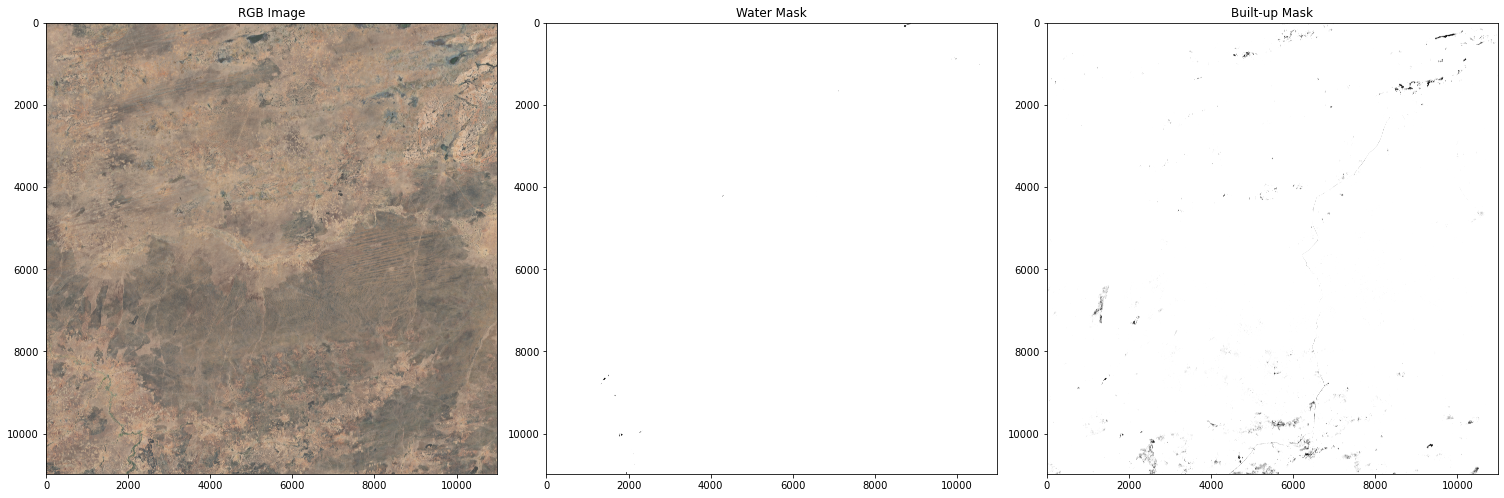

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))

def gamma_correction(image, gamma=1.5):
    """Apply gamma correction to enhance brightness."""
    return np.clip(image ** (1/gamma), 0, 1)

def apply_clahe(band):
    """Apply CLAHE to enhance local contrast."""
    band = (band * 255).astype(np.uint8)  # Convert to 8-bit
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(band) / 255.0  # Rescale to [0,1]

red = gamma_correction(apply_clahe(B04 / 10000), gamma=1.8)
green = gamma_correction(apply_clahe(B03 / 10000), gamma=1.8)
blue = gamma_correction(apply_clahe(B02 / 10000), gamma=1.8)

rgb = np.dstack((red, green, blue))
ax1.imshow(rgb / np.max(rgb))
ax1.set_title('RGB Image')

# Display Water Mask
ax2.imshow(np.squeeze(water_mask), cmap='gray')
ax2.set_title('Water Mask')

# Display Built-up Mask
ax3.imshow(np.squeeze(builtup_mask), cmap='gray')
ax3.set_title('Built-up Mask')

plt.tight_layout()
plt.show()

We can see that especially the built-up index is not doing very well in this area. For now, we will improve the results a bit by applying erosion and dilation. A better option to improve this filter is to train a land cover model, but this is outside of the scope of this project.

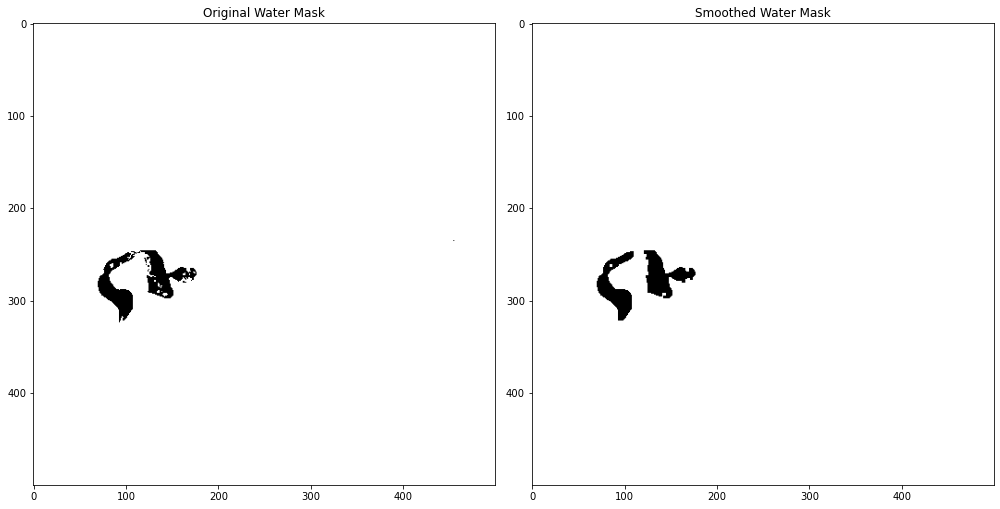

In [44]:
kernel = np.ones((3, 3), np.uint8)

# Apply erosion and dilation to the water- and builtup masks
water_mask_opened = cv2.morphologyEx(np.squeeze(water_mask), cv2.MORPH_OPEN, kernel)
water_mask_smoothed = cv2.morphologyEx(water_mask_opened, cv2.MORPH_CLOSE, kernel)

builtup_mask_opened = cv2.morphologyEx(np.squeeze(builtup_mask), cv2.MORPH_OPEN, kernel)
builtup_mask_smoothed = cv2.morphologyEx(builtup_mask_opened, cv2.MORPH_CLOSE, kernel)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

y_start = 9750
y_end = 10250
x_start = 1700
x_end = 2200

ax1.imshow(np.squeeze(np.squeeze(water_mask)[y_start:y_end, x_start:x_end]), cmap='gray')
ax1.set_title('Original Water Mask')

ax2.imshow(np.squeeze(water_mask_smoothed[y_start:y_end, x_start:x_end]), cmap='gray')
ax2.set_title('Smoothed Water Mask')

plt.tight_layout()
plt.show()

We will now combine these masks into one and export them to mask our Sentinel-2 images.

In [47]:
combined_mask = water_mask_smoothed * builtup_mask_smoothed

mask_file_path = '../data/combined_mask20250223.jp2'
mask_meta = src_B04.meta.copy()
mask_meta.update(dtype=rasterio.uint16, count=1)

with rasterio.open(mask_file_path, 'w', **mask_meta) as dst:
    dst.write(combined_mask, 1)

print(f"Combined mask exported to {mask_file_path}")

Combined mask exported to ../data/combined_mask20250223.jp2
